In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime as dt
from math import log, sqrt, exp, pi
from scipy.stats import norm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
N = norm.cdf

class Option:

    def __init__(self, spot, strike, maturity, rate, vol):
        self.spot = spot
        self.strike = strike
        self.maturity = maturity
        self.rate = rate
        self.vol = vol

    def d1(self, add_vol: int = None):
        vol = add_vol if add_vol else self.vol
        return (np.log(self.spot / self.strike) + (self.rate + vol ** 2 / 2) * self.maturity) / (vol* np.sqrt(self.maturity))

    def d2(self, add_vol: int = None):
        vol = add_vol if add_vol else self.vol
        return self.d1() - vol * np.sqrt(self.maturity)

    def call_price(self, add_vol: int = None):
        return self.spot * norm.cdf(self.d1(add_vol)) - self.strike * np.exp(-self.rate * self.maturity) * norm.cdf(self.d2(add_vol))

    def put_price(self, add_vol: int = None):
        return self.strike * np.exp(-self.rate * self.maturity) * norm.cdf(-self.d2(add_vol)) - self.spot * norm.cdf(-self.d1(add_vol))

    def call_implied_vol(self, target_price: int, tol:int = .001):
        sigma = tol
        while sigma < 1:
            temp_price = self.call_price(sigma)
            if abs(target_price - temp_price)<tol:
                return sigma
            else:
                sigma += tol
        return "Error when solving!"

    def put_implied_vol(self, target_price: int, tol:int = .001):
        sigma = tol
        while sigma < 1:
            temp_price = self.put_price(sigma)
            if abs(target_price - temp_price)<tol:
                return sigma
            else:
                sigma += tol
        return "Error when solving!"

    def call_delta(self):
        return norm.cdf(self.d1())

    def put_delta(self):
        return -norm.cdf(-self.d1())

    def call_gamma(self):
        return norm.pdf(self.d1()) / (self.spot * self.vol * sqrt(self.maturity))

    def put_gamma(self):
        return self.call_gamma()

    def call_vega(self):
        return self.spot * np.sqrt(self.maturity) * norm.pdf(self.d1())

    def put_vega(self):
        return self.call_vega()

    def call_theta(self):
        return - ((self.spot * norm.pdf(self.d1()) * self.vol ) / (2 * self.maturity)) - self.rate * self.strike * np.exp(
            - self.rate * self.maturity) * norm.cdf(self.d2())

    def put_theta(self):
        return - ((self.spot * norm.pdf(self.d1()) * self.vol) / (2 * self.maturity)) + self.rate * self.strike * np.exp(
            - self.rate * self.maturity) * norm.cdf(self.d2())

    def call_rho(self):
        return self.strike * self.maturity * np.exp(- self.rate * self.maturity) * norm.cdf(self.d2())

    def put_rho(self):
        return self.strike * self.maturity * np.exp(- self.rate * self.maturity) * norm.cdf(self.d2())

    def get_details(self, kind: str):
        full_info = {
            "Option Price": self.call_price() if kind == "call" else self.put_price(),
            "Option Delta": self.call_delta() if kind == "call" else self.put_delta(),
            "Option Gamma": self.call_gamma() if kind == "call" else self.put_gamma(),
            "Option Vega": self.call_vega() if kind == "call" else self.put_vega(),
            "Option Theta": self.call_theta() if kind == "call" else self.put_theta(),
            "Option Rho": self.call_rho() if kind == "call" else self.put_rho()
        }
        return full_info




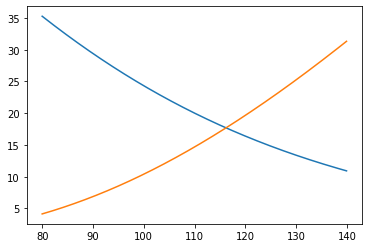

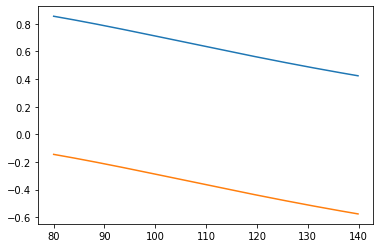

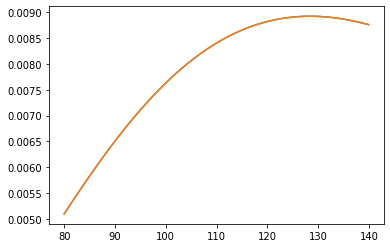

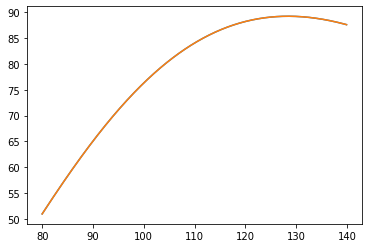

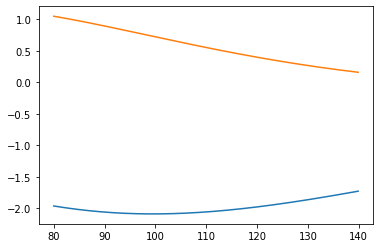

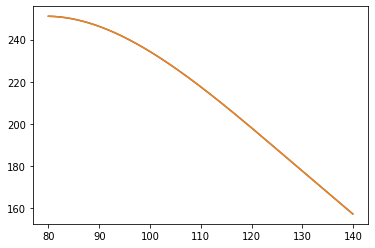

In [3]:
x = np.arange(80, 140, 0.1)
for target in Option(100, 100, 5, 0.03, 0.2).get_details("call").keys():
    plt.plot(x, [Option(100, i, 5, 0.03, 0.2).get_details("call")[target] for i in x])
    plt.plot(x, [Option(100, i, 5, 0.03, 0.2).get_details("put")[target] for i in x])
    plt.show()